In [ ]:
!pip -q install accelerate peft bitsandbytes transformers trl datasets gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 707.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 678.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 MB 852.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 875.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 938.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 826.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 846.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310

In [ ]:
#import torch
import time
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, pipeline, logging
import datetime
import torch
from datasets import load_dataset, Dataset
import statistics
from peft import LoraConfig, get_peft_model, PeftModel
from trl import SFTTrainer
import gradio as gr
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
drive.mount('/content/gdrive')

KeyboardInterrupt: 

In [ ]:
remote_directory = '/content/gdrive/My Drive/cse_291_project'
train_data = pd.read_json(f'{remote_directory}/data/finetune_train.jsonl', lines=True) #load_dataset('json', data_files=f'{remote_directory}/data/finetune_train.jsonl', split='train')
train_data = Dataset.from_pandas(train_data[train_data['completion'].str.len() <= 128])

saved_models_path = "/content/gdrive/My Drive/cse_291_project/models"
eval_data = pd.read_json(f'{remote_directory}/data/finetune_eval.jsonl', lines=True)

size = 7
chat = '-chat' # -chat
train_model = False
tuning_type = '-instruction' #'-instruction' #
num_shots = 5

new_model_id = f"Llama-2-{size}b{chat}{tuning_type}-hf-satire"
model_type = f'{size}{chat}-{tuning_type}'

save_tuned_eval_path = f'{remote_directory}/data/finetune_{size}{chat}_{tuning_type}_eval.jsonl'
logging_dir = f'{remote_directory}/logs'
log_df_training = f'{remote_directory}/logs/{new_model_id}_training_log.csv'
saved_satire_model_path = os.path.join(saved_models_path, new_model_id)
eval_data[model_type] = None

if chat == '-base':
  chat = ''

model_id = f"meta-llama/Llama-2-{size}b{chat}-hf"

print(f'Saved model path: {new_model_id}')
print(f'Loading mode: {model_id}')
print(len(train_data))
print(len(eval_data))

if not os.path.exists(saved_models_path):
    os.makedirs(saved_models_path)

token=None # change to private hugging face token

NameError: name 'Dataset' is not defined

In [ ]:
#df = pd.read_json(f'{remote_directory}/data/finetune_train.jsonl', lines=True)

def plot_leb_dist(df):
  completions = df['completion'].tolist()
  plt.hist([len(text) for text in completions], bins=100, edgecolor='black')  # Adjust the number of bins as needed
  plt.xlabel('Text Length')
  plt.ylabel('Frequency')
  plt.title('Distribution of Data Lengths')
  plt.grid(False)
  plt.show()
  plt.savefig('data_length_distribution.png')

  lens = [len(completion) for completion in completions]
  print(f'Mean length: {statistics.mean(lens)}')
  print(f'Median length: {statistics.median(lens)}')
  print(f'Min length: {min(lens)}')
  print(f'Max length: {max(lens)}')
  print(f'Num examples: {len(lens)}')

#plot_leb_dist(df)

#df = df[df['completion'].str.len() <= 128]
#plot_leb_dist(df)

In [ ]:
def prep_few_shot_train_data(df, num_shots):
  cols = []
  for i in range(num_shots):
    #cols.append(f'prompt_{i}')
    cols.append(f'example_{i}')
  few_shot_train_data = pd.DataFrame(columns=cols)

  for i in range(0, len(df), num_shots):
      if i + num_shots - 1 > len(df) - 1:
          break
      df_chunk = df.loc[i:i + num_shots]
      rows = {}
      for shot in range(num_shots):
          rows[f'example_{shot}'] = df_chunk.iloc[shot]["completion"]
      few_shot_train_data = pd.concat([few_shot_train_data, pd.DataFrame([rows])], ignore_index=True)
      #print(f'{i}. {i*5}. len: {len(few_shot_train_data)}')
  return few_shot_train_data

if tuning_type == 'few_shot':
  df = pd.read_json(f'{remote_directory}/data/finetune_train.jsonl', lines=True)
  few_shot_train_data = Dataset.from_pandas(prep_few_shot_train_data(df, num_shots))

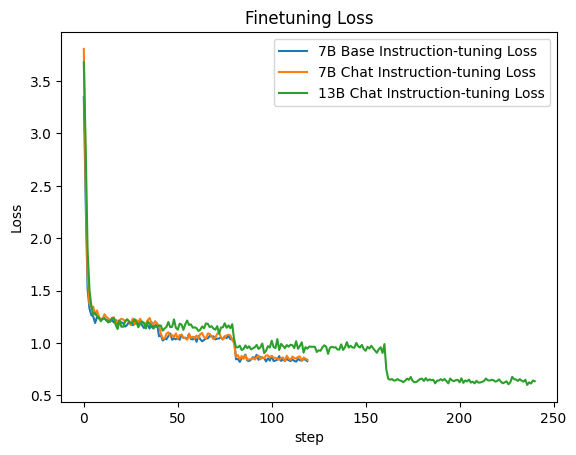

In [ ]:
# instruction
df = pd.read_csv(f'{remote_directory}/logs/Llama-2-7b-hf_instruction_tuning_training_log.csv')
loss_7b_base_instruction = df['loss'].tolist()

df = pd.read_csv(f'{remote_directory}/logs/Llama-2-7b-chat-hf_instruction_tuning_training_log.csv')
loss_7b_chat_instruction = df['loss'].tolist()

df = pd.read_csv(f'{remote_directory}/logs/Llama-2-13b-chat-hf_instruction_tuning_training_log.csv')
loss_13b_chat_instruction = df['loss'].tolist()
'''
# few shot
df = pd.read_csv(f'{remote_directory}/logs/Llama-2-7b-few_shot-hf-satire_training_log.csv')
loss_7b_base_few_shot = df['loss'].tolist()

df = pd.read_csv(f'{remote_directory}/logs/Llama-2-7b-chat-few_shot-hf-satire_training_log.csv')
loss_7b_chat_few_shot = df['loss'].tolist()

df = pd.read_csv(f'{remote_directory}/logs/Llama-2-13b-chat-few_shot-hf-satire_training_log.csv')
loss_13b_chat_few_shot = df['loss'].tolist()
'''
plt.plot(loss_7b_base_instruction, label='7B Base Instruction-tuning Loss')
plt.plot(loss_7b_chat_instruction, label='7B Chat Instruction-tuning Loss')
plt.plot(loss_13b_chat_instruction, label='13B Chat Instruction-tuning Loss')
'''
plt.plot(loss_7b_base_few_shot, label='7B Base Few-shot-tuning Loss')
plt.plot(loss_7b_chat_few_shot, label='7B Chat Few-shot-tuning Loss')
plt.plot(loss_13b_chat_few_shot, label='13B Chat Few-shot-tuning Loss')
'''
plt.xlabel('step')
plt.ylabel('Loss')
plt.title('Finetuning Loss')
plt.grid(False)
plt.legend()
plt.savefig('training_loss.png')
plt.show()


In [ ]:
#
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          token=token,
                                          padding_side="right",
                                          trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

PROMPT = 'You are creating satirical news headlines.'
PROMPT_FEWSHOT = 'You are creating satirical news headlines. Here are some examples and generate a similar one.'
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

def formatting_func(input):
    instruction = input['prompt']
    completion = input['completion']
    return B_INST + B_SYS + PROMPT + E_SYS + instruction + E_INST + completion

def formatting_func_few_shot(examples): # has k examples
    s = B_INST + B_SYS + PROMPT_FEWSHOT + E_SYS + E_INST + '\n'
    for i in range(num_shots):
      s += examples[f'example_{i}'] + '\n'
    return s

def generation_formatting_func(instruction):
    return B_INST + B_SYS + PROMPT + E_SYS + instruction + "Do not explain the headline." + E_INST

def generation_formatting_func_few_shot(instruction):
    return B_INST + B_SYS + PROMPT_FEWSHOT + E_SYS + E_INST

def formatting_func2(input):
    return f"### Prompt: {input['prompt']}\n ### Answer: {input['completion']}"
    #return {"prompt": tokenizer(input['prompt']), "completion": tokenizer(input['completion'])}

In [ ]:
lora_config = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.1,
    r=32,
        target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias='none',
    task_type='CAUSAL_LM',
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map='auto',
                                             quantization_config=bnb_config,
                                             #attn_implementation="flash_attention_2",
                                             token=token,
                                             torch_dtype=torch.float16)
model = get_peft_model(model, lora_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
if size == 7:
  batch_size = 16
elif size == 13:
  batch_size = 8
else:
  batch_size = 1

formatting_func = formatting_func
if tuning_type == 'few_shot':
  train_data = few_shot_train_data
  batch_size = 4 # 4 for 7b
  formatting_func = formatting_func_few_shot

training_args = TrainingArguments(
    output_dir=saved_models_path, # The output directory
    num_train_epochs=3,    # Total number of training epochs
    per_device_train_batch_size=batch_size,  # Batch size for training
    #per_device_eval_batch_size=4,   # Batch size for evaluation
    optim='paged_adamw_8bit',
    #bf16=True,
    #tf32=True,
    warmup_ratio=0.03,
    #fp16=True, # half precision
    weight_decay=0.001,               # Strength of weight decay
    learning_rate=2e-4,
    logging_dir=logging_dir,            # Directory for storing logs
    do_eval=False,
    group_by_length=True,
    logging_steps=10,
    save_steps=50,
    disable_tqdm=True
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    tokenizer=tokenizer,
    peft_config=lora_config,
    packing=True,
    formatting_func=formatting_func,
    max_seq_length=128
)

model.config.use_cache = False
model.config.use_reentrant = False

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
if train_model:
  model.train()
  print(f'Training')
  start_time = time.time()
  trainer.train()
  end_time = time.time()
  trainer.model.save_pretrained(saved_satire_model_path)
  trainer.tokenizer.save_pretrained(saved_satire_model_path)
  ft_model = model
  ft_model.config.use_cache = True
  model.config.use_reentrant = True

  training_duration = end_time - start_time
  print(f"Training took {training_duration:.4f} seconds")

In [ ]:
log_hist = pd.DataFrame(trainer.state.log_history)
print(log_hist.head())
log_hist.to_csv(log_df_training)

In [ ]:
saved_satire_model_path = os.path.join(saved_models_path, 'Llama-2-7b-chat-hf-satire')
ft_model = PeftModel.from_pretrained(model, saved_satire_model_path)
ft_model.eval()

tokenizer = AutoTokenizer.from_pretrained(saved_satire_model_path,
                                          token=token,
                                          padding_side="right",
                                          trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

def remove_substring(string, substring):
    return string.replace(substring, "")

def cut_off_text(text, prompt):
    index = text.find(prompt)
    if index != -1:
        return text[:index]
    else:
        return text

In [ ]:
batch_size = 24

#eval_data = pd.read_json(f'{remote_directory}/data/finetune_eval.jsonl', lines=True)
first_None_idx = eval_data[model_type].last_valid_index() if eval_data[model_type].last_valid_index() != None else 0
print(f'Start eval from row {first_None_idx}.')

j = 0 #first_None_idx
start_time = time.time()
with torch.autocast(device_type='cuda', dtype=torch.float16):
    for i in range(first_None_idx, len(eval_data), batch_size): #range(first_None_idx, len(eval_data), batch_size):
        batch = eval_data.iloc[i:i+batch_size]
        prompts = [generation_formatting_func(entry["prompt"]) for _, entry in batch.iterrows()]
        tokenized_prompts = tokenizer(prompts, return_tensors='pt', padding=True, truncation=True).to('cuda')

        generated_tokens = ft_model.generate(**tokenized_prompts,
                                             max_new_tokens=128,
                                             eos_token_id=tokenizer.eos_token_id,
                                             pad_token_id=tokenizer.eos_token_id)
        generated = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        for idx, (_, entry) in enumerate(batch.iterrows()):
            output = cut_off_text(generated[idx], '</s>')
            output = remove_substring(output, prompts[idx])
            output = remove_substring(output, '\n')
            eval_data[model_type][j] = output
            j += 1

        eval_data.to_json(save_tuned_eval_path, lines=True, orient='records')
        print(f"Saving progress. {i+batch_size}/{len(eval_data)}")
end_time = time.time()
evaluating_duration = end_time - start_time
print(f"Evaluating took {evaluating_duration:.4f} seconds")
eval_data.to_json(save_tuned_eval_path, lines=True, orient='records')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Start eval from row 0.


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 24/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 48/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 72/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 96/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 120/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 144/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 168/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 192/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 216/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 240/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 264/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 288/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 312/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 336/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 360/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 384/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 408/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 432/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 456/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 480/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 504/532


A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Saving progress. 528/532
Saving progress. 552/532
Evaluating took 576.9930 seconds


In [ ]:
launch_gradio = True

def clean_model_output(prompt, output):
  output = cut_off_text(output, '</s>')
  output = remove_substring(output, prompt)
  output = remove_substring(output, '\n')
  if ':' in output:
    output = output.split(':')[1]
  #if "\"" in output:
  #  output = output.split('"')[1]
  return output

def serve_gradio_request(prompt):
  with torch.autocast(device_type='cuda', dtype=torch.float16):
    formatted_prompt = generation_formatting_func(prompt)
    tokenized_prompt = tokenizer(formatted_prompt, return_tensors='pt', padding=True, truncation=True).to('cuda')
    generated_tokens = ft_model.generate(**tokenized_prompt,
                                          max_new_tokens=128,
                                          eos_token_id=tokenizer.eos_token_id,
                                          pad_token_id=tokenizer.eos_token_id)
    generated = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    output = clean_model_output(formatted_prompt, generated[0])
    return output

demo = gr.Interface(
  fn=serve_gradio_request,
  inputs=["text"],
  outputs=["text"],
)

if launch_gradio:
  demo.launch(debug=True)

# Generate a satirical headline that makes fun of an existing conspiracy. Don't explain the headline.
# Generate a satirical headline about r/wallstreetbets. Don't explain the headline.
# Generate a satirical headline about fat cats. Don't explain the headline.
# Generate a funny headline about college students not finding jobs. Don't explain the headline. -> "Local Colleges Offer New Major in 'Unemployment Studies' as Students Struggle to Find Jobs After Graduation"

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://504d64d3a2025b9a90.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://504d64d3a2025b9a90.gradio.live


In [ ]:
import re
import urllib.parse

def is_url_encoded(s):
    pattern = r'%[0-9a-fA-F]{2}'
    return re.search(pattern, s) is not None

path_map = {
    0: f'{remote_directory}/data/finetune_base_eval.jsonl',
    1: f'{remote_directory}/data/finetune_7-chat_-instruction_eval.jsonl',
    2: f'{remote_directory}/data/finetune_13-chat_instruction_eval.jsonl'
}
name_map = {0: 'base-finetuned',
            1: 'chat-finetuned',
            2: '13-chat-'
            }

bleu_scores = {}
smoother = SmoothingFunction()
weights = (0.5, 0.5, 0, 0)
reference_strings = [] # use groundtruths
results = pd.read_json(path_map[2], lines=True)
for i, row in results.iterrows():
  reference_strings.append(row['completion'].split())

for idx in range(3):
  avg_blue_score = 0
  print(f'Testing: {path_map[idx]}')
  results = pd.read_json(path_map[idx], lines=True)
  print(results.columns)
  for i, row in results.iterrows():
    #print(row)
    #print(*results.iloc[0],sep='\n')
    prompt = row['prompt']
    groundtruth = row['completion']
    generated = row[name_map[idx]]
    if prompt in generated:
      generated = generated.replace(prompt, '')
    '''generated = generated.replace('$}}%>', '').strip()
    generated = generated.replace('Breaking:', '').strip()
    generated = generated.replace('Sure, I can help you with that!', '').strip()
    generated = generated.replace('Sure thing!', '').strip()
    if 'Here are some satirical news headlines based on your question:' in generated:
      generated = generated.replace('Here are some satirical news headlines based on your question:', '').strip()
      generated = generated.split('\"')[1].strip() # only take the first example
    if is_url_encoded(generated):
      generated = urllib.parse.unquote(generated)
    generated = generated.replace('Sure!', '').strip()
    if ':' in generated:
      generated = generated.split(':')[1].strip()
    generated = generated.replace('}]]', '').strip()
    generated = generated.replace('}]', '').strip()
    generated = generated.replace('$}}<', '').strip()
    generated = generated.replace('$}}[/instances/meta/wikimediacommons-id]]', '').strip()
    generated = generated.replace('$}}[]{                                       %2', '').strip()'''
    #print(f'{prompt}\n{groundtruth}\n{generated}\n\n')

    bleu_score = sentence_bleu(reference_strings, generated.split(), weights=weights, smoothing_function=smoother.method1)
    avg_blue_score += (bleu_score) / (i+1)
  print(f'avg_blue_score for {name_map[idx]} = {avg_blue_score}')
  bleu_scores[name_map[idx]] = avg_blue_score

Testing: /content/gdrive/My Drive/cse_291_project/data/finetune_base_eval.jsonl
Index(['prompt', 'completion', 'chat-finetuned', 'base-finetuned'], dtype='object')
avg_blue_score for base-finetuned = 0.5820344922213863
Testing: /content/gdrive/My Drive/cse_291_project/data/finetune_7-chat_-instruction_eval.jsonl
Index(['prompt', 'completion', 'chat-finetuned', '7-chat--instruction'], dtype='object')
avg_blue_score for chat-finetuned = 0.43852133795116616
Testing: /content/gdrive/My Drive/cse_291_project/data/finetune_13-chat_instruction_eval.jsonl
Index(['prompt', 'completion', 'chat-finetuned', '13-chat-'], dtype='object')
avg_blue_score for 13-chat- = 0.5068452932159658


4-gram bleu scores

avg_blue_score for base-finetuned = 0.20015728343923805

avg_blue_score for chat-finetuned = 0.16737293044638854

avg_blue_score for 13-chat- = 0.11210672368398555